In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import tifffile
import matplotlib.pyplot as plt
import cv2

import random

In [2]:
DEFAULT_RANDOM_SEED = 2021

seed = DEFAULT_RANDOM_SEED

random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
'''DATA LOADER'''
class SWEDDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None, target_transform=None, index=True):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.target_transform = target_transform
        self.index = index

        self.data_dir = os.path.join(root_dir, mode)
        self.image_dir = os.path.join(self.data_dir, 'images')
        self.label_dir = os.path.join(self.data_dir, 'labels')
        
        image_files = sorted([f for f in os.listdir(self.image_dir) 
                            if f.endswith('.npy' if mode in ['train', 'val'] else '.tif')])
        label_files = sorted([f for f in os.listdir(self.label_dir) 
                            if f.endswith('.npy' if mode in ['train', 'val'] else '.tif')])
        
        self.pairs = []
        label_suffix = '_chip_' if mode in ['train', 'val'] else '_label_'
        image_dict = {f.replace('_image_', label_suffix): f for f in image_files}
        
        for label_file in label_files:
            if label_file in image_dict:
                self.pairs.append((image_dict[label_file], label_file))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_file, label_file = self.pairs[idx]
        img_path = os.path.join(self.image_dir, img_file)
        label_path = os.path.join(self.label_dir, label_file)
        
        if self.mode in ['train', 'val']:
            image = np.load(img_path)
            label = np.load(label_path)
        else:
            image = tifffile.imread(img_path)
            label = tifffile.imread(label_path)
            
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
        
        if self.mode in ['train', 'val']:
            image = image.permute(2, 0, 1)
        elif self.mode == 'test':
            image = image.permute(0, 2, 1)
            label = label.unsqueeze(0)
            label = torch.rot90(label, 1, [1, 2])
            label = torch.flip(label, [1])

        image = image / 2.0**15     # jp2 images are 8 to 16 bit
        label = label > 0.0         # binary label

        # bands: B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, B12
        if self.index:
            ndwi1 = (image[2] - image[7]) / (image[2] + image[7] + 1e-6)
            
            # downsample
            lowres = image[2].T.cpu().numpy()
            original_shape = lowres.shape
            lowres = cv2.resize(
                lowres, 
                (lowres.shape[1] // 2, lowres.shape[0] // 2), 
                interpolation=cv2.INTER_CUBIC
            )
            lowres = cv2.resize(
                lowres, 
                (original_shape[1], original_shape[0]), 
                interpolation=cv2.INTER_CUBIC
            )
            lowres = torch.from_numpy(lowres.T).float()

            ndwi2 = (lowres - image[10]) / (lowres + image[10] + 1e-6)

            image = torch.cat([image, ndwi1.unsqueeze(0), ndwi2.unsqueeze(0)], dim=0)
            
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [4]:
'''GET DATA LOADER'''
def get_dataloaders(root_dir, batch_size=32, num_workers=4, train_transform=None, test_transform=None, device='cuda'):
    train_dataset = SWEDDataset(root_dir, mode='train', transform=train_transform)
    test_dataset = SWEDDataset(root_dir, mode='test', transform=test_transform)

    # train_dataset, val_dataset, _ = random_split(train_dataset, [int(0.01 * len(train_dataset)), 
    #                                                              int(0.01 * len(train_dataset)), 
    #                                                              len(train_dataset) - int(0.02 * len(train_dataset))])

    train_dataset, val_dataset = random_split(train_dataset, [int(0.8 * len(train_dataset)),  
                                                                 len(train_dataset) - int(0.8 * len(train_dataset))])

    print(f'Train size: {len(train_dataset)}')
    print(f'Validation size: {len(val_dataset)}')
    print(f'Test size: {len(test_dataset)}')
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

In [5]:
'''DISPLAY SAMPLES'''
def display_samples(dataloader, num_samples=5, index=True):
    # Get a batch
    images, masks = next(iter(dataloader))

    # Move to CPU for visualization
    images = images.cpu()
    masks = masks.cpu()

    # Only display up to the requested number of samples
    num_samples = min(num_samples, len(images))
    
    rows = 4 if index else 2
    fig, axes = plt.subplots(rows, num_samples, figsize=(5*num_samples, 5*rows))
    
    idx = 0
    while(idx < num_samples):
        i = np.random.randint(0, len(images))
        if masks[i].sum() == 0:
            continue

        # Display RGB channels (assuming bands 3,2,1 are RGB)
        rgb_img = images[i][[3,2,1]].permute(1,2,0)
        # Normalize for visualization
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
        
        axes[0, idx].imshow(rgb_img)
        axes[0, idx].axis('off')
        axes[0, idx].set_title(f'Image {idx+1}')
        
        axes[1, idx].imshow(masks[i][0], cmap='gray')
        axes[1, idx].axis('off')
        axes[1, idx].set_title(f'Mask {idx+1}')

        if index:
            axes[2, idx].imshow(images[i][12], cmap='gray')
            axes[2, idx].axis('off')
            axes[2, idx].set_title(f'NDWI1 {idx+1}')

            axes[3, idx].imshow(images[i][13], cmap='gray')
            axes[3, idx].axis('off')
            axes[3, idx].set_title(f'NDWI2 {idx+1}')

        idx += 1
    
    plt.tight_layout()
    plt.show()

In [6]:
'''VISUALIZE SAMPLES'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f"Using device: {device}")

root_dir = "/kaggle/input/sentinel-2-water-edges-dataset/SWED"
train_loader, val_loader, test_loader = get_dataloaders(root_dir, batch_size=16, num_workers=4)

# Display 5 samples from training set
# display_samples(train_loader, num_samples=5)
# display_samples(test_loader, num_samples=5)

'''
# in case we need standardization

channel-wise mean:  tensor([ 532.5187,  636.4246,  892.5240, 1049.9366, 1307.1577, 1738.9155,
        1915.7476, 1995.0083, 2055.7939, 2086.2705, 2001.6875, 1491.3577])
channel-wise std:  tensor([ 679.3956,  750.0253,  923.6580, 1273.5732, 1366.0400, 1500.5621,
        1623.3806, 1687.1169, 1720.2144, 1827.5625, 1932.8875, 1631.7715])
'''

Using device: cuda
Train size: 22579
Validation size: 5645
Test size: 98


'\n# in case we need standardization\n\nchannel-wise mean:  tensor([ 532.5187,  636.4246,  892.5240, 1049.9366, 1307.1577, 1738.9155,\n        1915.7476, 1995.0083, 2055.7939, 2086.2705, 2001.6875, 1491.3577])\nchannel-wise std:  tensor([ 679.3956,  750.0253,  923.6580, 1273.5732, 1366.0400, 1500.5621,\n        1623.3806, 1687.1169, 1720.2144, 1827.5625, 1932.8875, 1631.7715])\n'

In [7]:
!pip install -q --upgrade torchmetrics
!pip install -q einops

In [8]:
'''TRAINER CLASS'''
from tqdm import tqdm
from torchmetrics.classification import (
    BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryJaccardIndex, 
    BinaryCohenKappa, BinaryMatthewsCorrCoef, Accuracy
)
import pandas as pd

class Trainer:
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, test_loader, device, 
                 scheduler=None, early_stopping_patience=15, min_delta=0.001):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.scheduler = scheduler
        self.predictions = None

        # Early stopping parameters
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.early_stopping_counter = 0
        self.early_stopped = False

    def save_checkpoint(self, epoch, train_loss, val_loss, best_model=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }
        if self.scheduler:
            checkpoint['scheduler_state_dict'] = self.scheduler.state_dict()

        if best_model:
            save_path = 'best_model.pt'
        else:
            save_path = 'checkpoint.pt'
        torch.save(checkpoint, save_path)
    
    def load_checkpoint(self, checkpoint_path="best_model.pt"):
        if not os.path.exists(checkpoint_path):
            return 0  # Start from scratch if no checkpoint exists
            
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if self.scheduler and 'scheduler_state_dict' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Restore loss history
        self.train_losses = checkpoint.get('train_losses', [])
        self.val_losses = checkpoint.get('val_losses', [])
        
        return checkpoint['epoch']

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for images, labels in tqdm(self.train_loader, desc="train"):
        # for images, labels in self.train_loader:
            images, labels = images.to(self.device), labels.to(self.device).float()
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        return running_loss / len(self.train_loader.dataset)

    def val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="validation"):
            # for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device).float()
                outputs = self.model(images)
                loss = self.criterion(outputs.squeeze(), labels.squeeze())
                running_loss += loss.item() * images.size(0)
        
        return running_loss / len(self.val_loader.dataset)
    
    def plot_losses(self, train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()
    
    def train(self, num_epochs, do_plot=True, plot_interval=5, resume=True):
        # Initialize or restore from checkpoint
        self.train_losses = []
        self.val_losses = []
        start_epoch = self.load_checkpoint('checkpoint.pt') if resume else 0
        self.best_val_loss = float('inf')
        self.early_stopping_counter = 0
        self.early_stopped = False

        if start_epoch > 0:
            print("Training resumed from epoch ", start_epoch)
    
        for epoch in range(start_epoch, num_epochs):
            if self.early_stopped:
                print("Early stopping triggered.")
                break

            train_loss = self.train_epoch()
            val_loss = self.val_epoch()
    
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            if self.scheduler:
                self.scheduler.step(val_loss)
    
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"Training Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")

            self.save_checkpoint(epoch + 1, train_loss, val_loss)
    
            # Early stopping logic
            if val_loss < self.best_val_loss - self.min_delta:
                self.best_val_loss = val_loss
                self.early_stopping_counter = 0
                # Save the best model
                self.save_checkpoint(epoch + 1, train_loss, val_loss, best_model=True)
                print(f"New best model saved at epoch {epoch + 1}")
            else:
                self.early_stopping_counter += 1
                print(f"No improvement. Early stopping counter: {self.early_stopping_counter}")
                
                if self.early_stopping_counter >= self.early_stopping_patience:
                    self.early_stopped = True
                    print("Early stopping triggered.")
    
            if do_plot and (epoch % plot_interval == 0 or epoch == num_epochs - 1):
                self.plot_losses(self.train_losses, self.val_losses)
        
        # Load the best model at the end of training
        if os.path.exists('best_model.pt'):
            self.load_checkpoint('best_model.pt')
        
        return self.early_stopped


    def test(self, thres=0.5):
        self.load_checkpoint('best_model.pt')
        self.model.eval()
        running_loss = 0.0
        all_predictions = []
        y_true = None
        y_pred = None

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device).float()
                outputs = self.model(images)

                if y_true is None:
                    y_true = labels.squeeze().cpu().numpy()
                    y_pred = (outputs.squeeze().cpu().numpy() > thres).astype(int)
                else:
                    y_true = np.concatenate((y_true, labels.squeeze().cpu().numpy()))
                    y_pred = np.concatenate((y_pred, (outputs.squeeze().cpu().numpy() > 0.5).astype(int)))
                
                loss = self.criterion(outputs.squeeze(), labels.squeeze())
                running_loss += loss.item() * images.size(0)
                all_predictions.extend(outputs.squeeze().cpu().numpy())

        metrics = self.evaluate_torchmetrics(y_pred, y_true)
        metrics.loc[len(metrics)] = ['loss', running_loss / len(self.test_loader.dataset)]  

        return metrics

    def evaluate_torchmetrics(self, y_pred, y_true):
        metrics = {
            "accuracy": BinaryAccuracy(),
            "bal_accuracy": Accuracy(num_classes=2, task="multiclass", average="macro"),
            "precision": BinaryPrecision(),
            "recall": BinaryRecall(),
            "f1_score": BinaryF1Score(),
            "jaccard_index": BinaryJaccardIndex(),
            "cohen_kappa": BinaryCohenKappa(),
            "mcc": BinaryMatthewsCorrCoef()
        }
    
        y_pred = torch.tensor(y_pred).float()
        y_true = torch.tensor(y_true).float()
    
        # result dataframe
        results = pd.DataFrame(columns=["Metric", "Value"])
        for metric_name, metric in metrics.items():
            metric_value = metric(y_pred, y_true)
            results.loc[len(results)] = [metric_name, metric_value.item()]  
            
        return results

    def test_visualize(self, n_samples=5, thres=0.5): 
        self.model.eval()
        y_true = None
        y_pred = None

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device).float()
                outputs = self.model(images)

                if y_true is None:
                    y_true = labels.squeeze().cpu().numpy()
                    y_pred = (outputs.squeeze().cpu().numpy() >thres).astype(int)
                else:
                    y_true = np.concatenate((y_true, labels.squeeze().cpu().numpy()))
                    y_pred = np.concatenate((y_pred, (outputs.squeeze().cpu().numpy() > 0.5).astype(int)))
                
        for _ in range(n_samples):
            idx = random.randint(0, len(y_true))
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(y_true[idx].reshape(256, 256), cmap='gray')
            axes[0].set_title('True')
            axes[1].imshow(y_pred[idx].reshape(256, 256), cmap='gray')
            axes[1].set_title('Predicted')
            plt.show()


In [9]:
channels = 14

In [10]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class Mlp_Relu(nn.Module):

    def __init__(self, in_features, hidden_features, out_features, dropout):
        super(Mlp_Relu, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # Swin v1
        # define a parameter table of relative position bias
        # self.relative_position_bias_table = nn.Parameter(
        #     torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2

        # Swin v1
        # relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        # relative_coords[:, :, 1] += self.window_size[1] - 1
        # relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        # relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        # self.register_buffer("relative_position_index", relative_position_index)

        # Swin v2, log-spaced coordinates, Eq.(4)
        # log_relative_position_index = torch.mul(torch.sign(relative_coords), torch.log(torch.abs(relative_coords) + 1))
        log_relative_position_index = torch.sign(relative_coords) * torch.log(1. + relative_coords.abs())
        self.register_buffer("log_relative_position_index", log_relative_position_index)

        # Swin v2, small meta network, Eq.(3)
        self.cpb = Mlp_Relu(in_features=2,  # delta x, delta y
                            hidden_features=256,  # hidden dims
                            out_features=self.num_heads,
                            dropout=0.0)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        # Swin v1
        # trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

        # Swin v2, Scaled cosine attention
        self.tau = nn.Parameter(torch.ones((num_heads, window_size[0] * window_size[1],
                                            window_size[0] * window_size[1])))

    def get_continuous_relative_position_bias(self, N):
        # The continuous position bias approach adopts a small meta network on the relative coordinates
        continuous_relative_position_bias = self.cpb(self.log_relative_position_index[:N, :N])
        return continuous_relative_position_bias

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # Swin v1
        # q = q * self.scale
        # attn = (q @ k.transpose(-2, -1))

        # Swin v2, Scaled cosine attention
        # q = q * self.scale
        # qk = q @ k.transpose(-2, -1)
        # q2 = torch.mul(q, q).sum(-1).sqrt().unsqueeze(3)
        # k2 = torch.mul(k, k).sum(-1).sqrt().unsqueeze(3)
        # attn = qk / torch.clip(q2 @ k2.transpose(-2, -1), min=1e-6)
        # attn = attn / torch.clip(self.tau[:, :N, :N].unsqueeze(0), min=0.01)

        # Swin v2, Scaled cosine attention
        q = q * self.scale
        attn = torch.einsum("bhqd, bhkd -> bhqk", q, k) / torch.maximum(
            torch.norm(q, dim=-1, keepdim=True) * torch.norm(k, dim=-1, keepdim=True).transpose(-2, -1),
            torch.tensor(1e-06, device=q.device, dtype=q.dtype))
        attn = attn / torch.clip(self.tau[:, :N, :N].unsqueeze(0), min=0.01)

        # Swin v1
        # relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
        #     self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH

        # Swin v2
        relative_position_bias = self.get_continuous_relative_position_bias(N)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x

        # Swin v1
        # x = self.norm1(x)

        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # Swin v2
        x = self.norm1(x)

        # FFN
        x = shortcut + self.drop_path(x)

        # Swin v1
        # x = x + self.drop_path(self.mlp(self.norm2(x)))

        # Swin v2
        x = x + self.drop_path(self.norm2(self.mlp(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class PatchExpand(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2 * dim, bias=False) if dim_scale == 2 else nn.Identity()
        self.norm = norm_layer(dim // dim_scale)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=2, p2=2, c=C // 4)
        x = x.view(B, -1, C // 4)
        x = self.norm(x)

        return x


class FinalPatchExpand_X4(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=4, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.dim_scale = dim_scale
        self.expand = nn.Linear(dim, 16 * dim, bias=False)
        self.output_dim = dim
        self.norm = norm_layer(self.output_dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale,
                      c=C // (self.dim_scale ** 2))
        x = x.view(B, -1, self.output_dim)
        x = self.norm(x)

        return x


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class BasicLayer_up(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, upsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if upsample is not None:
            self.upsample = PatchExpand(input_resolution, dim=dim, dim_scale=2, norm_layer=norm_layer)
        else:
            self.upsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.upsample is not None:
            x = self.upsample(x)
        return x


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformerSys(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030
    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=256, patch_size=4, in_chans=14, num_classes=1,
                 embed_dim=96, depths=[2, 2, 2, 2], depths_decoder=[1, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=True, final_upsample="expand_first", **kwargs):
        super().__init__()

        print(
            "SwinTransformerSys expand initial----depths:{};depths_decoder:{};drop_path_rate:{};num_classes:{}".format(
                depths,
                depths_decoder, drop_path_rate, num_classes))

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.num_features_up = int(embed_dim * 2)
        self.mlp_ratio = mlp_ratio
        self.final_upsample = final_upsample

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build encoder and bottleneck layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        # build decoder layers
        self.layers_up = nn.ModuleList()
        self.concat_back_dim = nn.ModuleList()
        for i_layer in range(self.num_layers):
            concat_linear = nn.Linear(2 * int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)),
                                      int(embed_dim * 2 ** (
                                                  self.num_layers - 1 - i_layer))) if i_layer > 0 else nn.Identity()
            if i_layer == 0:
                layer_up = PatchExpand(
                    input_resolution=(patches_resolution[0] // (2 ** (self.num_layers - 1 - i_layer)),
                                      patches_resolution[1] // (2 ** (self.num_layers - 1 - i_layer))),
                    dim=int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)), dim_scale=2, norm_layer=norm_layer)
            else:
                layer_up = BasicLayer_up(dim=int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)),
                                         input_resolution=(
                                         patches_resolution[0] // (2 ** (self.num_layers - 1 - i_layer)),
                                         patches_resolution[1] // (2 ** (self.num_layers - 1 - i_layer))),
                                         depth=depths[(self.num_layers - 1 - i_layer)],
                                         num_heads=num_heads[(self.num_layers - 1 - i_layer)],
                                         window_size=window_size,
                                         mlp_ratio=self.mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop_rate, attn_drop=attn_drop_rate,
                                         drop_path=dpr[sum(depths[:(self.num_layers - 1 - i_layer)]):sum(
                                             depths[:(self.num_layers - 1 - i_layer) + 1])],
                                         norm_layer=norm_layer,
                                         upsample=PatchExpand if (i_layer < self.num_layers - 1) else None,
                                         use_checkpoint=use_checkpoint)
            self.layers_up.append(layer_up)
            self.concat_back_dim.append(concat_linear)

        self.norm = norm_layer(self.num_features)
        self.norm_up = norm_layer(self.embed_dim)

        if self.final_upsample == "expand_first":
            print("---final upsample expand_first---")
            self.up = FinalPatchExpand_X4(input_resolution=(img_size // patch_size, img_size // patch_size),
                                          dim_scale=4, dim=embed_dim)
            self.output = nn.Conv2d(in_channels=embed_dim, out_channels=self.num_classes, kernel_size=1, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    # Encoder and Bottleneck
    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        x_downsample = []

        for layer in self.layers:
            x_downsample.append(x)
            x = layer(x)

        x = self.norm(x)  # B L C

        return x, x_downsample

    # Dencoder and Skip connection
    def forward_up_features(self, x, x_downsample):
        for inx, layer_up in enumerate(self.layers_up):
            if inx == 0:
                x = layer_up(x)
            else:
                x = torch.cat([x, x_downsample[3 - inx]], -1)
                x = self.concat_back_dim[inx](x)
                x = layer_up(x)

        x = self.norm_up(x)  # B L C

        return x

    def up_x4(self, x):
        H, W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "input features has wrong size"

        if self.final_upsample == "expand_first":
            x = self.up(x)
            x = x.view(B, 4 * H, 4 * W, -1)
            x = x.permute(0, 3, 1, 2)  # B,C,H,W
            x = self.output(x)

        return x

    def forward(self, x):
        x, x_downsample = self.forward_features(x)
        x = self.forward_up_features(x, x_downsample)
        x = self.up_x4(x)

        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('#### Test Model ###')
x = torch.rand(4, 14, 256, 256).to(device)
model = SwinTransformerSys().to(device)
y = model(x)
print(y.size())

#### Test Model ###
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---


/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


torch.Size([4, 1, 256, 256])


In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.65, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        pred, target = pred.squeeze(), target.squeeze()
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        return focal_loss.mean()

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


pred = torch.randn(16, 128, 128).float()
target = torch.randint(0, 2, (16, 128, 128)).float()

# focal_loss = FocalLoss(alpha=0.75, gamma=2.0)
# focal_loss(pred, target)
loss(pred, target)

tensor(13154.0391)

train:   0%|          | 0/1412 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
validation:   0%|          | 0/353 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
validation: 100%|██████████| 353/353 [01:03<00:00,  5.52it/s]


Epoch 1/50
Training Loss: 1447.9996
Validation Loss: 1301.2810
New best model saved at epoch 1


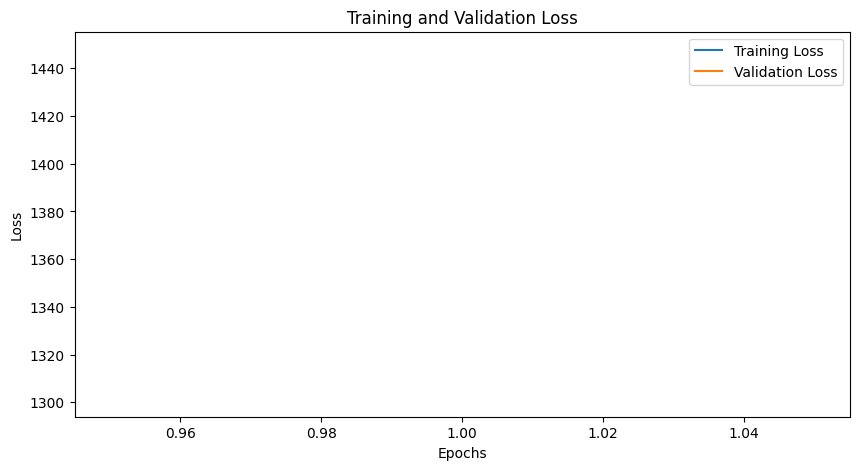

validation: 100%|██████████| 353/353 [00:47<00:00,  7.41it/s]


Epoch 2/50
Training Loss: 1145.9010
Validation Loss: 1050.8663
New best model saved at epoch 2


validation: 100%|██████████| 353/353 [00:57<00:00,  6.12it/s]


Epoch 3/50
Training Loss: 1145.4786
Validation Loss: 1163.4971
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [00:46<00:00,  7.54it/s]


Epoch 4/50
Training Loss: 1066.4219
Validation Loss: 1100.1789
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [00:58<00:00,  6.03it/s]


Epoch 5/50
Training Loss: 993.8590
Validation Loss: 813.0761
New best model saved at epoch 5


validation: 100%|██████████| 353/353 [00:48<00:00,  7.23it/s]


Epoch 6/50
Training Loss: 854.1551
Validation Loss: 1003.8650
No improvement. Early stopping counter: 1


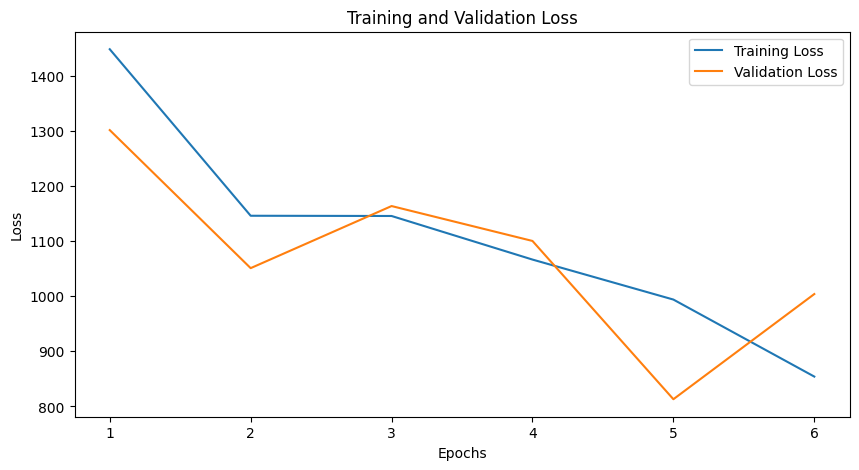

validation: 100%|██████████| 353/353 [01:00<00:00,  5.87it/s]


Epoch 7/50
Training Loss: 872.8736
Validation Loss: 805.3029
New best model saved at epoch 7


validation: 100%|██████████| 353/353 [00:46<00:00,  7.57it/s]


Epoch 8/50
Training Loss: 802.0998
Validation Loss: 822.8646
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [00:55<00:00,  6.31it/s]


Epoch 9/50
Training Loss: 762.3566
Validation Loss: 752.3452
New best model saved at epoch 9


validation: 100%|██████████| 353/353 [00:46<00:00,  7.65it/s]


Epoch 10/50
Training Loss: 751.1348
Validation Loss: 839.9504
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [00:58<00:00,  6.04it/s]


Epoch 11/50
Training Loss: 717.9263
Validation Loss: 659.5385
New best model saved at epoch 11


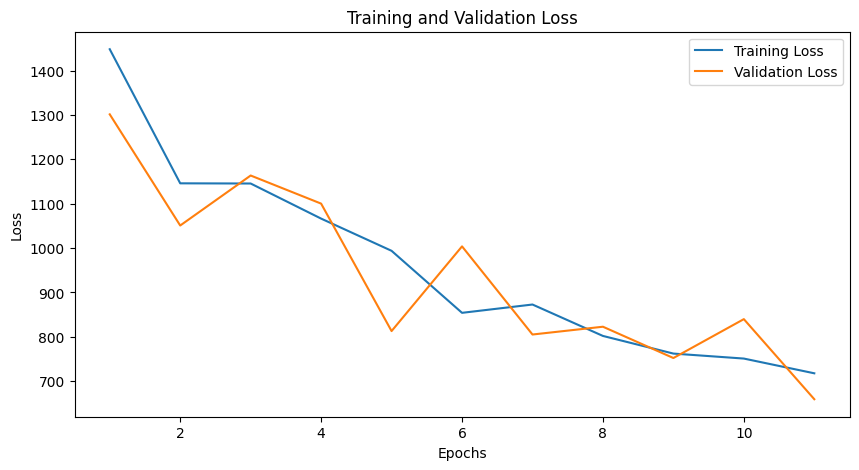

validation: 100%|██████████| 353/353 [00:48<00:00,  7.22it/s]


Epoch 12/50
Training Loss: 658.4785
Validation Loss: 572.4818
New best model saved at epoch 12


validation: 100%|██████████| 353/353 [00:59<00:00,  5.90it/s]


Epoch 13/50
Training Loss: 636.7303
Validation Loss: 582.7186
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [00:47<00:00,  7.38it/s]


Epoch 14/50
Training Loss: 607.1373
Validation Loss: 588.9682
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [00:57<00:00,  6.10it/s]


Epoch 15/50
Training Loss: 636.7840
Validation Loss: 668.1971
No improvement. Early stopping counter: 3


validation: 100%|██████████| 353/353 [00:48<00:00,  7.26it/s]


Epoch 16/50
Training Loss: 594.6422
Validation Loss: 591.1419
No improvement. Early stopping counter: 4


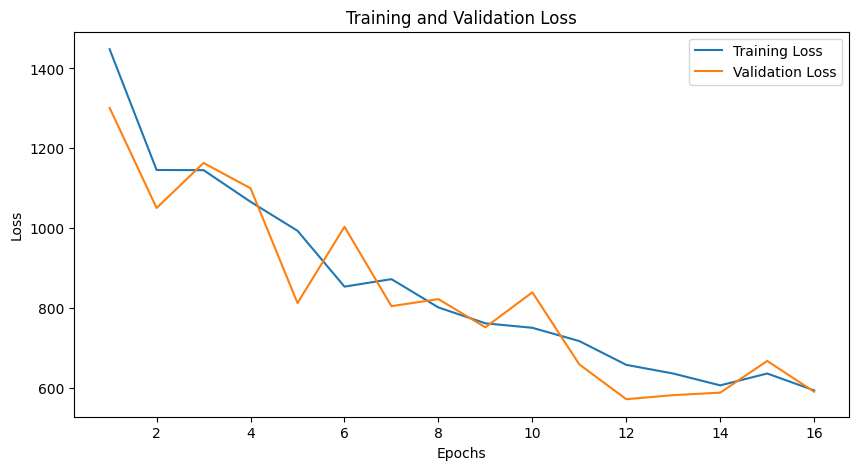

validation: 100%|██████████| 353/353 [01:00<00:00,  5.83it/s]


Epoch 17/50
Training Loss: 632.3233
Validation Loss: 622.5279
No improvement. Early stopping counter: 5


validation: 100%|██████████| 353/353 [00:47<00:00,  7.37it/s]


Epoch 18/50
Training Loss: 518.7001
Validation Loss: 507.6555
New best model saved at epoch 18


validation: 100%|██████████| 353/353 [01:00<00:00,  5.83it/s]


Epoch 19/50
Training Loss: 549.0230
Validation Loss: 670.2382
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [00:48<00:00,  7.21it/s]


Epoch 20/50
Training Loss: 535.3374
Validation Loss: 473.0651
New best model saved at epoch 20


validation: 100%|██████████| 353/353 [00:55<00:00,  6.39it/s]


Epoch 21/50
Training Loss: 501.7748
Validation Loss: 452.6683
New best model saved at epoch 21


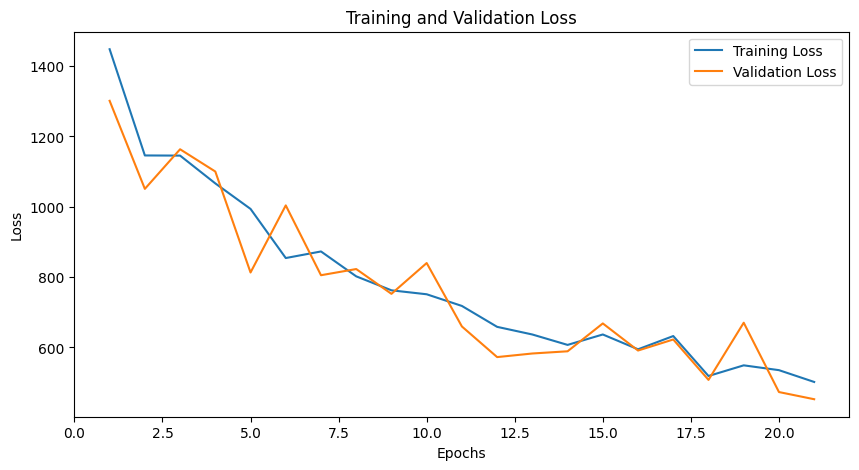

validation: 100%|██████████| 353/353 [00:50<00:00,  6.99it/s]


Epoch 22/50
Training Loss: 506.9115
Validation Loss: 458.0405
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [01:02<00:00,  5.68it/s]


Epoch 23/50
Training Loss: 480.8147
Validation Loss: 451.4870
New best model saved at epoch 23


validation: 100%|██████████| 353/353 [00:49<00:00,  7.15it/s]


Epoch 24/50
Training Loss: 487.4637
Validation Loss: 506.7430
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [01:00<00:00,  5.84it/s]


Epoch 25/50
Training Loss: 476.6717
Validation Loss: 452.8971
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [00:50<00:00,  6.93it/s]


Epoch 26/50
Training Loss: 472.0605
Validation Loss: 515.6076
No improvement. Early stopping counter: 3


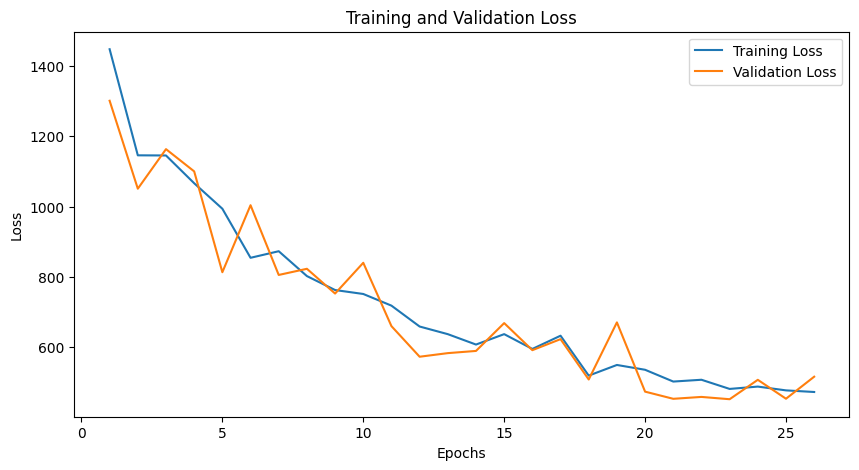

validation: 100%|██████████| 353/353 [01:03<00:00,  5.56it/s]


Epoch 27/50
Training Loss: 467.1724
Validation Loss: 717.3618
No improvement. Early stopping counter: 4


validation: 100%|██████████| 353/353 [00:47<00:00,  7.44it/s]


Epoch 28/50
Training Loss: 487.6940
Validation Loss: 421.8489
New best model saved at epoch 28


validation: 100%|██████████| 353/353 [00:54<00:00,  6.46it/s]


Epoch 29/50
Training Loss: 456.7692
Validation Loss: 447.7344
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [00:47<00:00,  7.43it/s]


Epoch 30/50
Training Loss: 452.1941
Validation Loss: 436.5067
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [00:55<00:00,  6.34it/s]


Epoch 31/50
Training Loss: 456.5442
Validation Loss: 411.2804
New best model saved at epoch 31


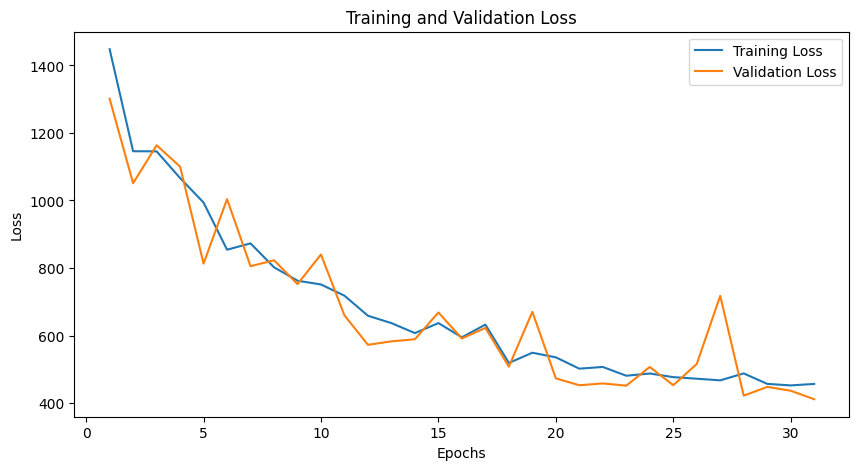

validation: 100%|██████████| 353/353 [00:49<00:00,  7.12it/s]


Epoch 32/50
Training Loss: 458.4287
Validation Loss: 450.5526
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [01:01<00:00,  5.79it/s]


Epoch 33/50
Training Loss: 479.9521
Validation Loss: 441.7367
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [00:49<00:00,  7.13it/s]


Epoch 34/50
Training Loss: 454.6005
Validation Loss: 463.8439
No improvement. Early stopping counter: 3


validation: 100%|██████████| 353/353 [00:58<00:00,  6.02it/s]


Epoch 35/50
Training Loss: 460.4791
Validation Loss: 488.5369
No improvement. Early stopping counter: 4


validation: 100%|██████████| 353/353 [00:48<00:00,  7.23it/s]


Epoch 36/50
Training Loss: 445.7602
Validation Loss: 426.0858
No improvement. Early stopping counter: 5


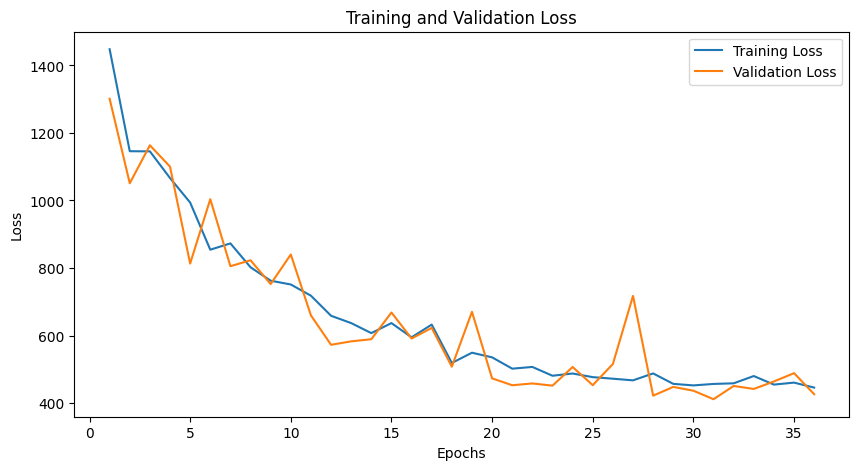

validation: 100%|██████████| 353/353 [01:02<00:00,  5.65it/s]


Epoch 37/50
Training Loss: 410.3772
Validation Loss: 404.9573
New best model saved at epoch 37


validation: 100%|██████████| 353/353 [00:48<00:00,  7.20it/s]


Epoch 38/50
Training Loss: 414.9321
Validation Loss: 392.3635
New best model saved at epoch 38


validation: 100%|██████████| 353/353 [01:01<00:00,  5.78it/s]


Epoch 39/50
Training Loss: 407.9662
Validation Loss: 399.7447
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [00:49<00:00,  7.18it/s]


Epoch 40/50
Training Loss: 404.9463
Validation Loss: 404.9469
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [01:01<00:00,  5.73it/s]


Epoch 41/50
Training Loss: 406.5310
Validation Loss: 404.5293
No improvement. Early stopping counter: 3


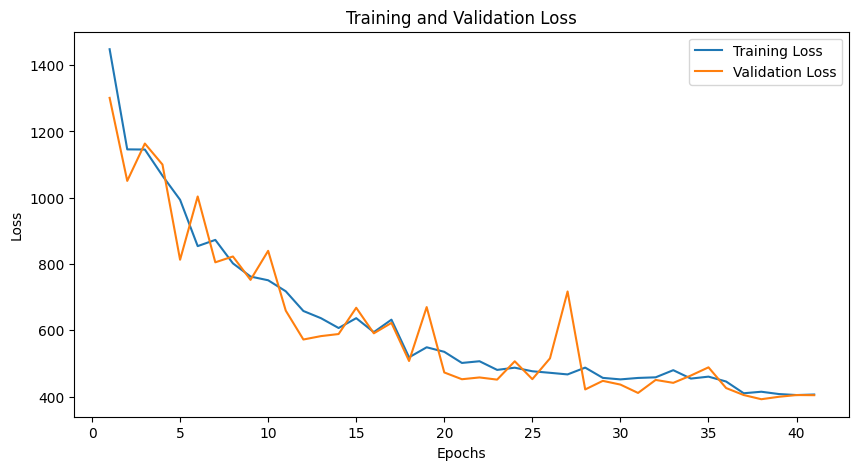

validation: 100%|██████████| 353/353 [00:47<00:00,  7.38it/s]


Epoch 42/50
Training Loss: 403.7751
Validation Loss: 391.9394
New best model saved at epoch 42


validation: 100%|██████████| 353/353 [01:01<00:00,  5.73it/s]


Epoch 43/50
Training Loss: 401.9138
Validation Loss: 402.9818
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [00:47<00:00,  7.43it/s]


Epoch 44/50
Training Loss: 394.2927
Validation Loss: 395.9026
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [00:59<00:00,  5.97it/s]


Epoch 45/50
Training Loss: 403.7376
Validation Loss: 407.3521
No improvement. Early stopping counter: 3


validation: 100%|██████████| 353/353 [00:49<00:00,  7.18it/s]


Epoch 46/50
Training Loss: 391.0526
Validation Loss: 402.5759
No improvement. Early stopping counter: 4


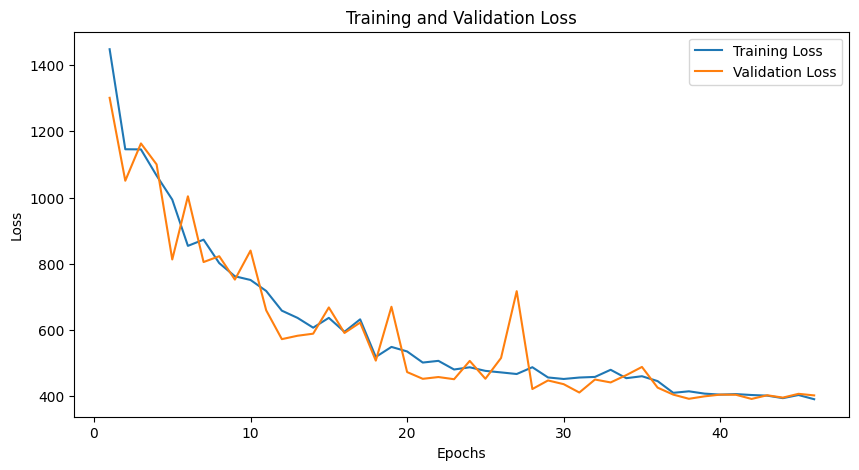

validation: 100%|██████████| 353/353 [01:04<00:00,  5.48it/s]


Epoch 47/50
Training Loss: 393.8685
Validation Loss: 406.6910
No improvement. Early stopping counter: 5


validation: 100%|██████████| 353/353 [00:53<00:00,  6.56it/s]


Epoch 48/50
Training Loss: 377.1139
Validation Loss: 377.4762
New best model saved at epoch 48


validation: 100%|██████████| 353/353 [01:03<00:00,  5.58it/s]


Epoch 49/50
Training Loss: 371.5478
Validation Loss: 370.7542
New best model saved at epoch 49


validation: 100%|██████████| 353/353 [00:44<00:00,  7.92it/s]


Epoch 50/50
Training Loss: 368.0213
Validation Loss: 369.5082
New best model saved at epoch 50


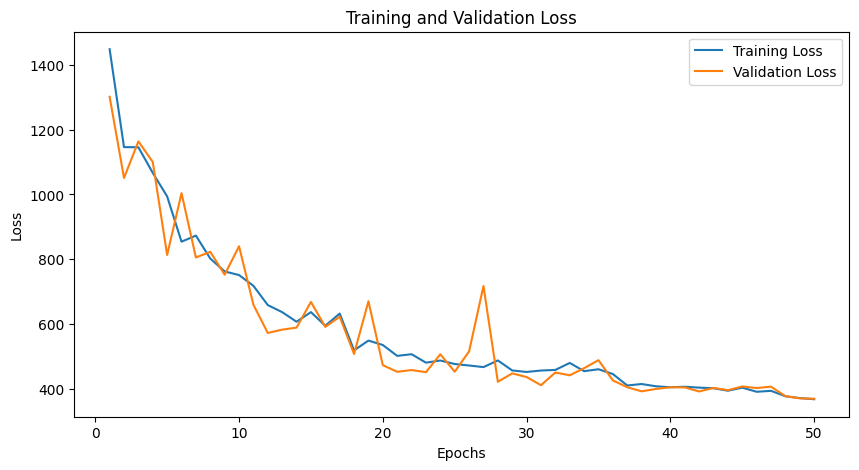

/tmp/ipykernel_23/1093936236.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


False

In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd

criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

trainer = Trainer(model, 
                  criterion, 
                  optimizer, 
                  train_loader, val_loader, test_loader, 
                  device, 
                  scheduler, 
                  early_stopping_patience=9
                 )
trainer.train(num_epochs=50)

In [13]:
metrics_df = trainer.test(thres=0.5)
metrics_df

/tmp/ipykernel_23/1093936236.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Testing: 100%|██████████| 7/7 [00:02<00:00,  2.63i

,Metric,Value
0,accuracy,0.896011
1,bal_accuracy,0.899060
2,precision,0.936364
3,recall,0.878040
4,f1_score,0.906264
5,jaccard_index,0.828596
6,cohen_kappa,0.789775
7,mcc,0.791835
8,loss,2433.337037


Testing:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Testing: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]


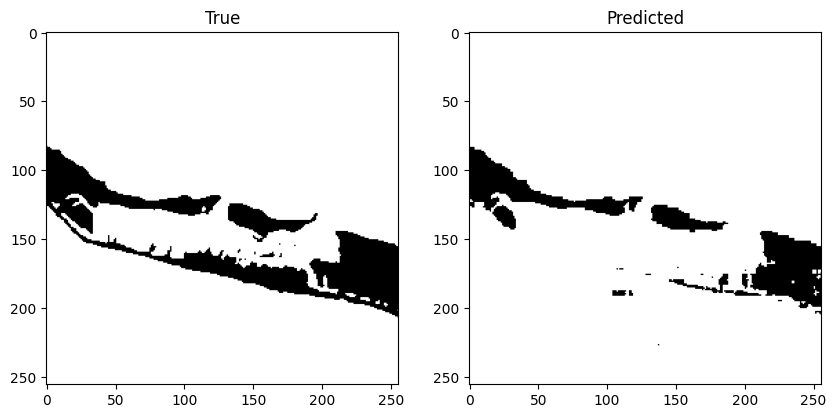

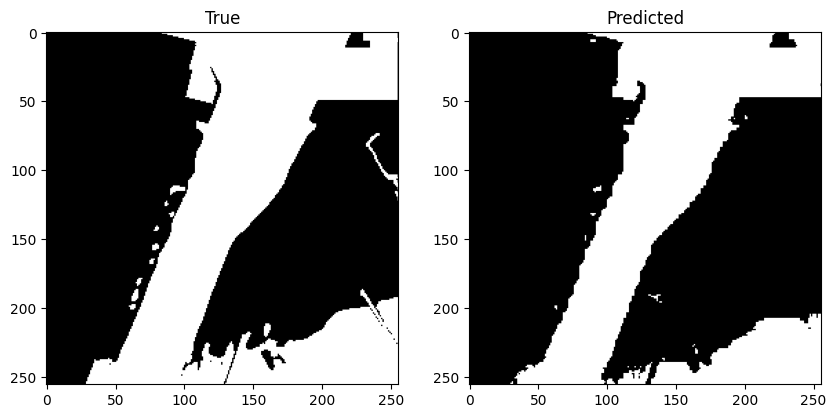

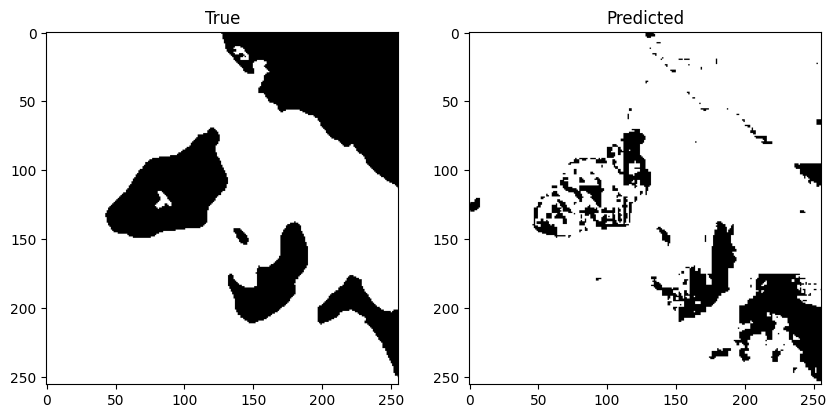

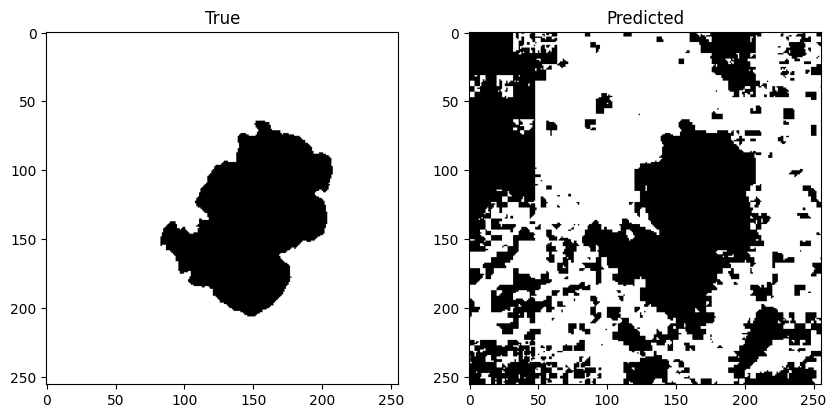

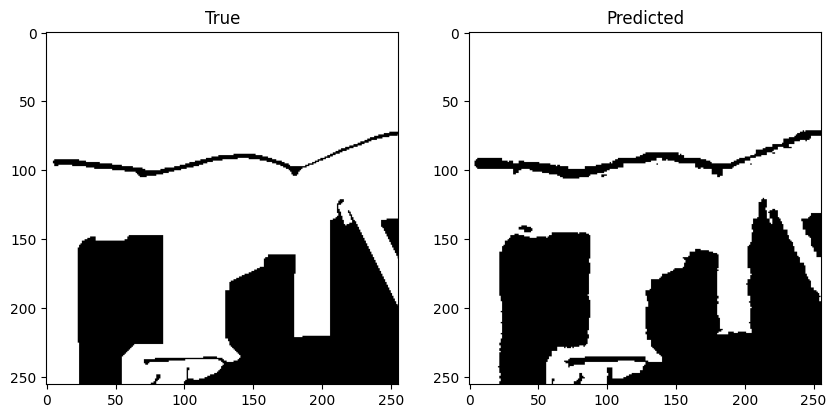

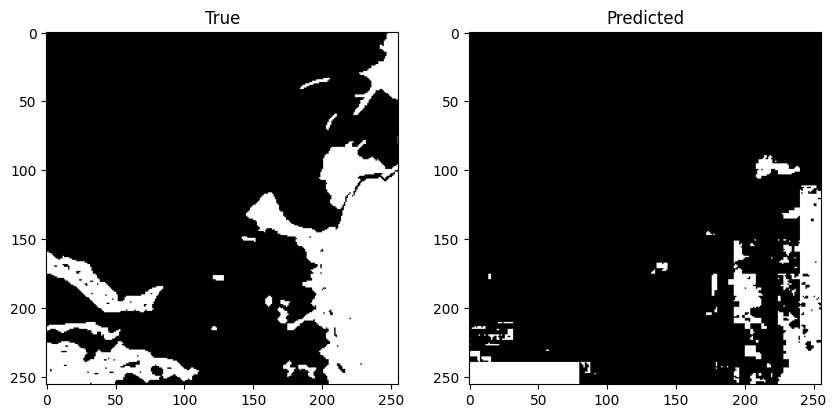

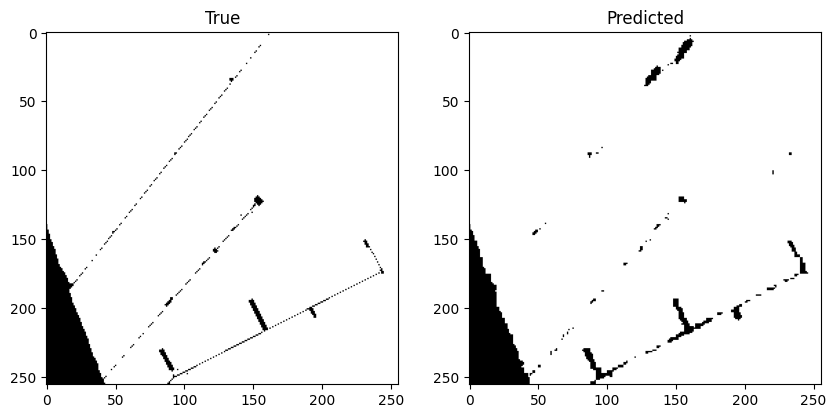

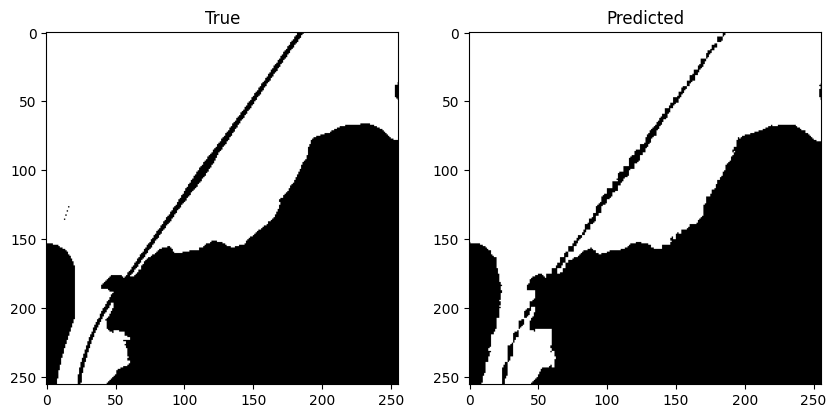

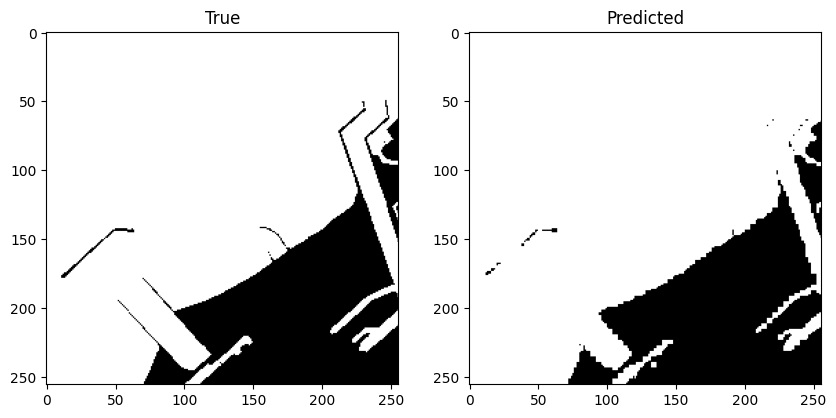

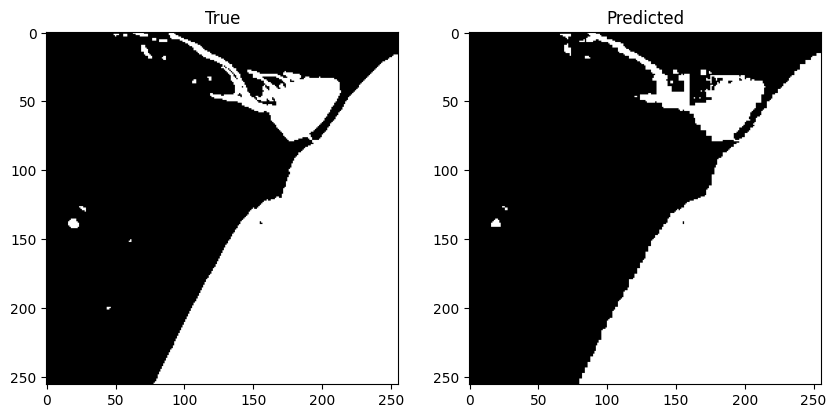

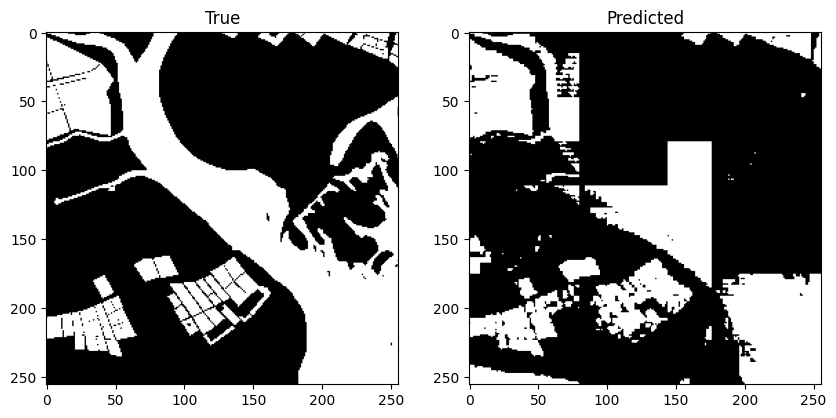

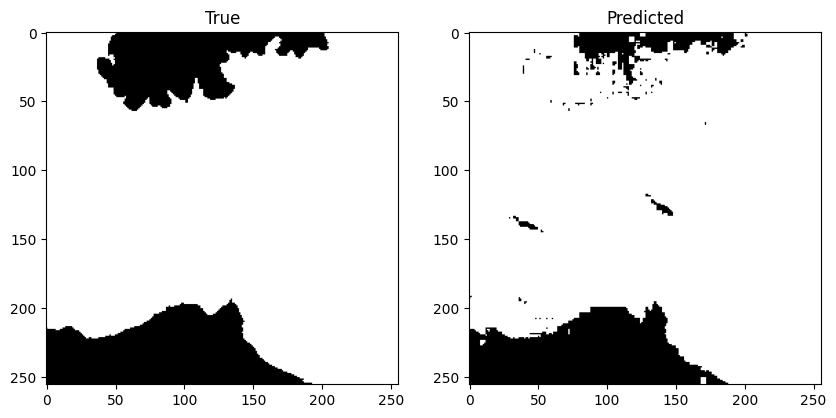

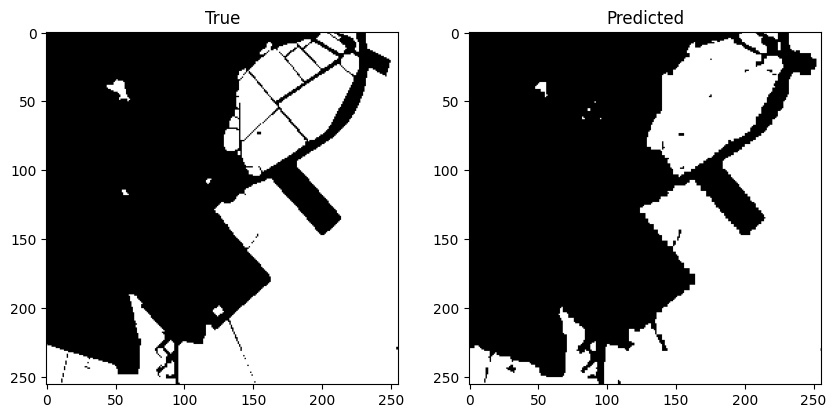

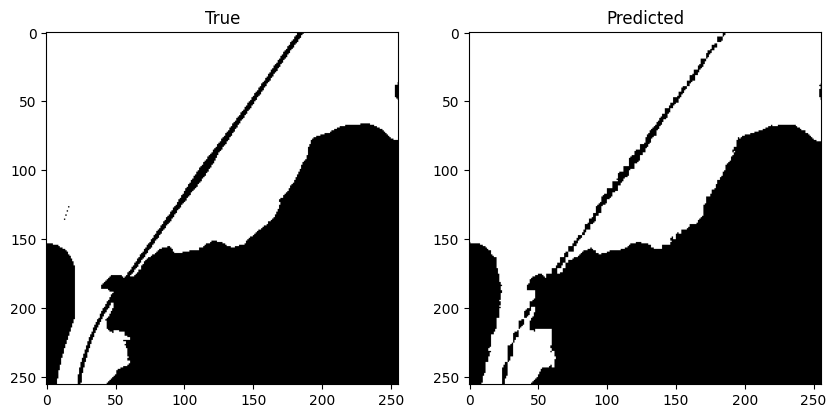

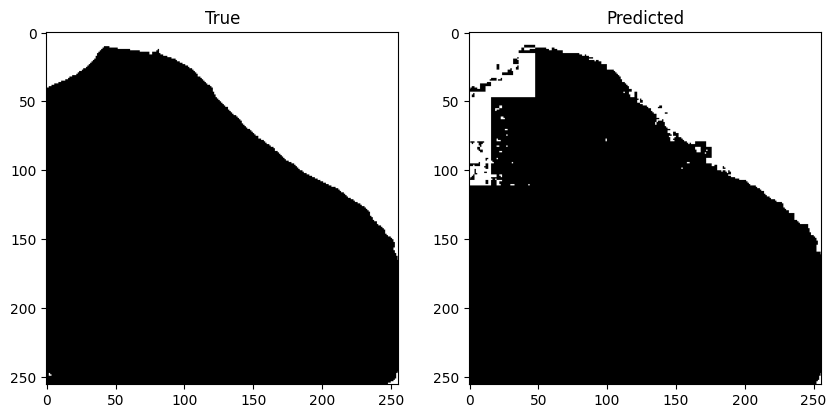

In [14]:
trainer.test_visualize(15, 0.5)

In [15]:
# !rm -r /kaggle/working/*